In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [ ]:
df = pd.read_csv(r'../data/National_only.csv')

In [50]:
def parse_ranges_to_dict(ranges):
    range_dict = {}
    for r in ranges:
        if '<' in r:
            start = 0
            end = float(r.split('<')[-1])
        elif '>=' in r:
            start = float(r.split('>=')[-1])
            end = start*2
        elif '-' in r:
            start, end = map(float, r.split('-'))
        else:
            raise ValueError(f"Invalid range format: {r}")
        range_dict[r] = (start, end)
    return range_dict



In [51]:

#columns that represent trip amounts per distance bin
cols = [x for x in df.columns if 'Number of Trips ' in x]

#Minimum and Maximum distance to belong to a specific bin
ranges = parse_ranges_to_dict([x.split(' ')[-1] for x in cols]).values()
distance_bins={}
for cname,(start,end) in zip(cols,ranges):
    distance_bins[cname]=(start+end)/2

In [52]:
cols

['Number of Trips <1',
 'Number of Trips 1-3',
 'Number of Trips 3-5',
 'Number of Trips 5-10',
 'Number of Trips 10-25',
 'Number of Trips 25-50',
 'Number of Trips 50-100',
 'Number of Trips 100-250',
 'Number of Trips 250-500',
 'Number of Trips >=500']

In [53]:
distance_bins

{'Number of Trips <1': 0.5,
 'Number of Trips 1-3': 2.0,
 'Number of Trips 3-5': 4.0,
 'Number of Trips 5-10': 7.5,
 'Number of Trips 10-25': 17.5,
 'Number of Trips 25-50': 37.5,
 'Number of Trips 50-100': 75.0,
 'Number of Trips 100-250': 175.0,
 'Number of Trips 250-500': 375.0,
 'Number of Trips >=500': 750.0}

## Sequential programming

In [54]:
new_rows = []

# Iterate through each row in df
for _, row in df.iterrows():
    # For each bin, create a new row with the corresponding distance and number of trips
    for col in cols:
        new_row = {
            'Distance': distance_bins[col],
            'Trips': row[col]
        }
        new_rows.append(new_row)

# Create a new dataframe with the new rows
df_new = pd.DataFrame(new_rows)

## Same operation, using Dask

In [55]:
import dask.dataframe as dd

In [56]:
# Convert the original dataframe to a Dask dataframe
df_dask = dd.from_pandas(df, npartitions=1)

# Provide metadata for the melt operation so Dask can infer the output structure.
# Here we expect a new dataframe with two columns: 'bin' (object) and 'Trips' (float64).
meta = {'bin': 'object', 'Trips': 'float64'}

# Use map_partitions to perform the melt operation on each partition of the Dask DataFrame.
# Provide metadata explicitly for the resulting DataFrame.
df_long = df_dask.map_partitions(
	lambda pdf: pdf.melt(id_vars=[], value_vars=cols, var_name='bin', value_name='Trips'),
	meta=meta
)

# Map the bin labels to their corresponding distances using the dictionary
df_long['Distance'] = df_long['bin'].map(distance_bins)


# Select only the relevant columns
df_new_dask = df_long[['Distance', 'Trips']]

# Compute the final result and display
print(df_new_dask.compute())

c:\Users\cohenl\Downloads\Big Data Project\v2\.venv\Lib\site-packages\dask\dataframe\dask_expr\_collection.py:4210: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map function that you are using.
  Before: .map(func)
  After:  .map(func, meta=('bin', 'float64'))

  warnings.warn(meta_warning(meta, method="map"))


      Distance        Trips
0          0.5  241667151.0
1          0.5  291276735.0
2          0.5  296375014.0
3          0.5  293159631.0
4          0.5  295459014.0
...        ...          ...
9005     750.0     971201.0
9006     750.0     940416.0
9007     750.0     978249.0
9008     750.0    1044153.0
9009     750.0     946339.0

[9010 rows x 2 columns]


In [57]:
print(f"The new dataframe has {df_new.shape[0]} rows, while the new dask dataframe has {df_new_dask.shape[0].compute()}")

The new dataframe has 9010 rows, while the new dask dataframe has 9010


## Now, we train a model to predict the amount of trips given a certain distance

In [58]:
from dask_ml.linear_model import LinearRegression
from dask_ml.model_selection import train_test_split


In [59]:
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:

# Convert the predictors and response to Dask arrays.
# Ensure they are 2D arrays as expected by scikit-learn API.
X = df_new_dask[['Distance']].to_dask_array(lengths=True)
y = df_new_dask['Trips'].to_dask_array(lengths=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = LinearRegression()

# Fit the model on the training data
model.fit(X_train, y_train)

LinearRegression()

In [ ]:

y_pred = model.predict(X_test)


In [62]:
# Compute the predictions and true values
y_pred_np = y_pred.compute()
y_test_np = y_test.compute()

# Use scikit-learn metrics
mse = mean_squared_error(y_test_np, y_pred_np)
r2 = r2_score(y_test_np, y_pred_np)

print("MSE:", mse)
print("R²:", r2)

MSE: 8598980080918075.0
R²: 0.35484378248381143


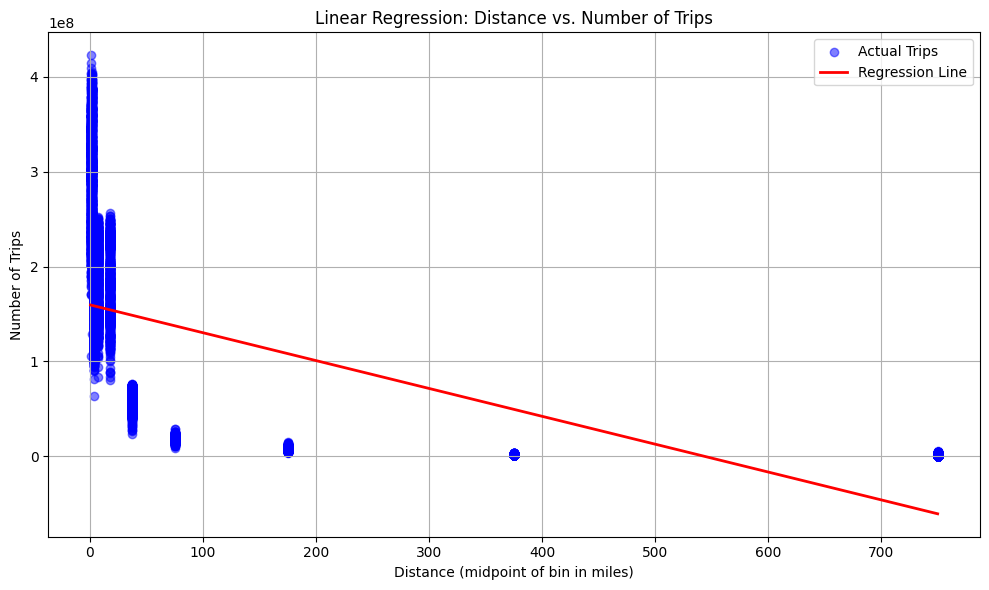

In [ ]:
X_np = X.compute()
y_np = y.compute()
y_pred_np = model.predict(X).compute()


plt.figure(figsize=(10, 6))
plt.scatter(X_np, y_np, color='blue', label='Actual Trips', alpha=0.5)
plt.plot(X_np, y_pred_np, color='red', label='Regression Line', linewidth=2)

plt.title('Linear Regression: Distance vs. Number of Trips')
plt.xlabel('Distance (midpoint of bin in miles)')
plt.ylabel('Number of Trips')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Without Dask

### As we can observe, this data is not ideal for linear regression, since more variables (like date) are needed in order to properly estimate the number of trips

#### We can, however, Use other statistical tools to better model the data